# Bottle Classification
by Isabella Moura

## Setup

In [ ]:
!pip install tensorflow
!pip install tensorflow_datasets
!pip install setuptools
!pip install matplotlib


In [ ]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## First Steps

 We will load the Xception model, pre-trained on ImageNet, and use it on the Kaggle "Bottles Synthetic Images" classification dataset.

### Getting the data

We will use the utility
`keras.utils.image_dataset_from_directory` to generate similar labeled
 dataset objects from a set of images on disk filed into class-specific folders.


In [38]:
train_ds, validation_ds = tf.keras.utils.image_dataset_from_directory(
directory='bottleimage/test', 
labels='inferred',
label_mode='int',
validation_split=0.2,
subset="both",
seed = 42,
batch_size=32,
image_size= (256,256),
interpolation="nearest",
shuffle=True)

Found 25000 files belonging to 5 classes.
Using 20000 files for training.
Using 5000 files for validation.


### Splitting the validation dataset into validation and test datasets:

In [39]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 2)
validation_ds = validation_ds.skip(val_batches // 2)

In [40]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of training batches: 625
Number of validation batches: 79
Number of test batches: 78


### Display Image and Labels

Selects one batch of images and labels from the training dataset.
- Loops through the first 9 images in this batch.
- Displays each image in a 3x3 grid of subplots.
- Sets the title of each subplot to the corresponding class name.
- Turns off the axis for each subplot to provide a clean view of the images.

2024-06-08 18:56:45.829380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


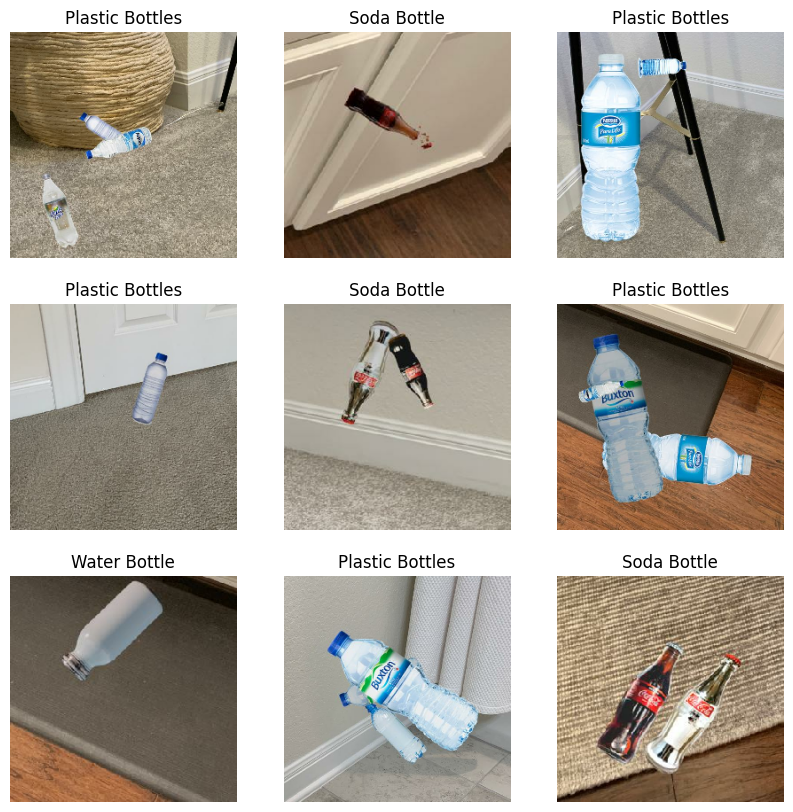

In [43]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [44]:
number_of_classes = len(train_ds.class_names)

### Standardizing the data

Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer
values between 0 and 255 (RGB level values). This isn't a great fit for feeding a
neural network. We need to do 2 things:

- Standardize to a fixed image size. We pick 150x150.
- Normalize pixel values between -1 and 1. We'll do this using a `Normalization` layer as
part of the model itself.

In general, it's a good practice to develop models that take raw data as input, as
opposed to models that take already-preprocessed data. The reason being that, if your
model expects preprocessed data, any time you export your model to use it elsewhere
(in a web browser, in a mobile app), you'll need to reimplement the exact same
preprocessing pipeline. This gets very tricky very quickly. So we should do the least
 possible amount of preprocessing before hitting the model.

Here, we'll do image resizing in the data pipeline (because a deep neural network can
only process contiguous batches of data), and we'll do the input value scaling as part
of the model, when we create it.

Let's resize images to 150x150:

In [11]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

### Using random data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to
the training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [12]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

2024-06-08 15:59:50.510191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


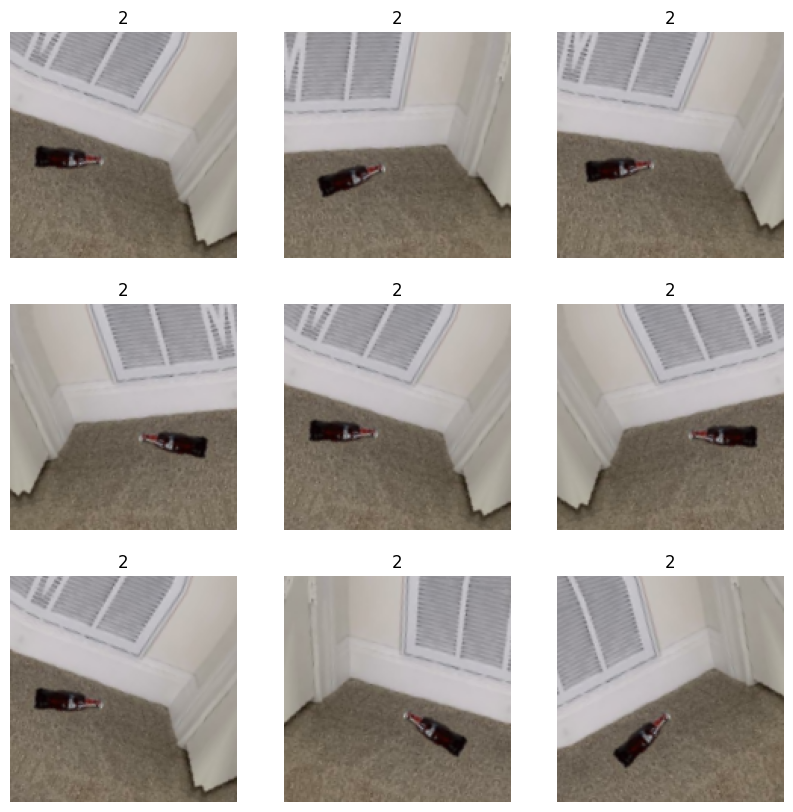

In [13]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## Build a model

This code sets up a transfer learning pipeline using the Xception model pre-trained on ImageNet, adding custom layers on top to adapt it for a specific classification task. The base model’s weights are frozen to leverage learned features, while the new layers are trained to fit the new dataset.

Note that:

- We add a `Rescaling` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

In [14]:
base_model = keras.applications.Xception( # Keras model 
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with Dropout
outputs = keras.layers.Dense(number_of_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 5)             │     10,245 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Train the top layer

- The model is compiled with the Adam optimizer.
- The loss function used is sparse_categorical_crossentropy which is suitable for classification problems with integer labels.
- The metric used to evaluate the model’s performance is accuracy.
- 	The model is trained for 4 epochs using the fit method.

In [15]:
model.compile(optimizer=keras.optimizers.Adam(),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'])

initial_epochs = 4
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 354s 564ms/step - accuracy: 0.6861 - loss: 0.7970 - val_accuracy: 0.8223 - val_loss: 0.4702
Epoch 2/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 375s 601ms/step - accuracy: 0.8183 - loss: 0.4937 - val_accuracy: 0.8474 - val_loss: 0.4282
Epoch 3/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 406s 650ms/step - accuracy: 0.8228 - loss: 0.4676 - val_accuracy: 0.8415 - val_loss: 0.4211
Epoch 4/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 432s 691ms/step - accuracy: 0.8372 - loss: 0.4414 - val_accuracy: 0.8458 - val_loss: 0.4124


### Plot Training and Validation Accuracy

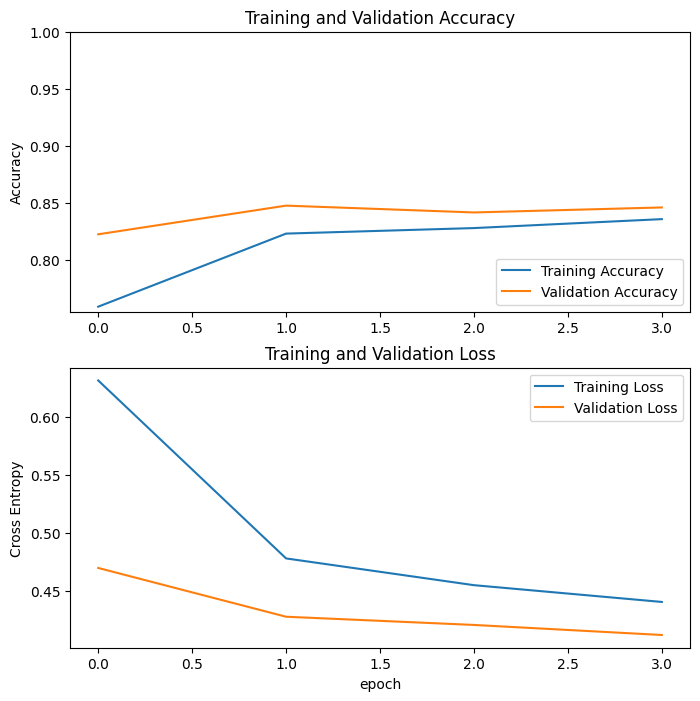

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Interpretation

- The base model shows a typical learning pattern where the training accuracy increases and training loss decreases over time.
- The validation metrics are stable, indicating that the model is not overfitting significantly during these initial epochs.
- The validation accuracy and loss remaining relatively stable suggest that the base model’s frozen layers provide a good starting point for the new task.

## Doing a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low
 learning rate.

Importantly, although the base model becomes trainable, it is still running in
inference mode since we passed `training=False` when calling it when we built the
model. This means that the batch normalization layers inside won't update their batch
statistics. If they did, they would wreck havoc on the representations learned by the
 model so far.

In [17]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.

base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

epochs = 1
print("Fitting the end-to-end model")
history_fine = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 5)             │     10,245 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,892,217 (79.70 MB)

 Trainable params: 20,817,197 (79.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 20,492 (80.05 KB)

Fitting the end-to-end model
625/625 ━━━━━━━━━━━━━━━━━━━━ 1845s 3s/step - accuracy: 0.7551 - loss: 0.6960 - val_accuracy: 0.9081 - val_loss: 0.2573


### Plot Training and Validation Accuracy:

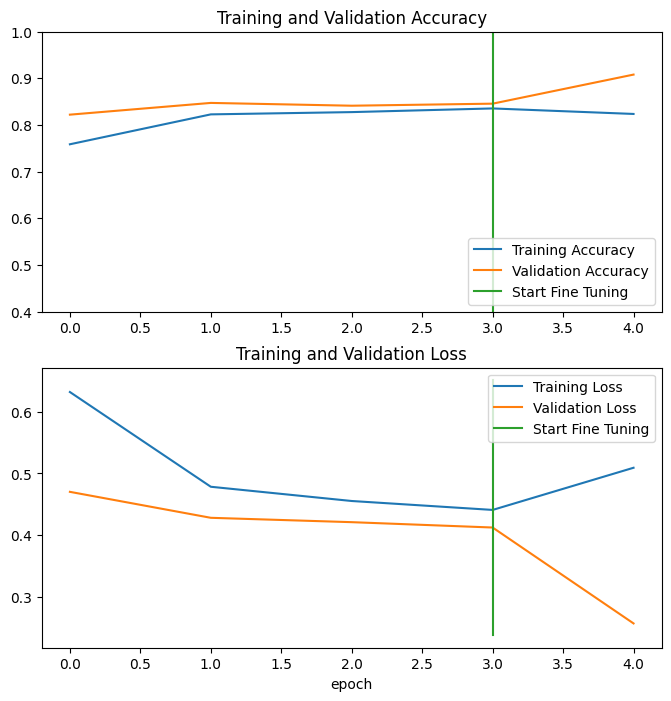

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1]) # set the y-axis limits
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

After 10 epochs, fine-tuning gains us a nice improvement here.
Let's evaluate the model on the test dataset:

In [19]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
78/78 ━━━━━━━━━━━━━━━━━━━━ 38s 488ms/step - accuracy: 0.9061 - loss: 0.2544


[0.241420716047287, 0.9146634340286255]

### Interpretation

- Fine-tuning the model after the initial training improves both training and validation accuracy, demonstrating that the model benefits from additional training of the base layers.
- The validation loss decreases notably after fine-tuning, suggesting that the model generalizes better to the validation set once the base layers are unfrozen and trained with a lower learning rate.
- The increase in both training and validation accuracy and the decrease in loss indicate that fine-tuning enhances the model’s performance on the specific task.


### Model Comparison
- The initial model leverages the pre-trained Xception network, focusing on training only the newly added layers.
- Fine-tuning involves retraining the entire network with a lower learning rate to refine the weights further, leading to potentially better performance by adjusting all layers, including the pre-trained ones.
- Structure: Both models have the same structure, with the difference being the trainability of the base Xception layers.
- Training: The initial model trains only the top layers, while the fine-tuned model trains the entire network.
- Compilation: Both models use the same loss function and metric, but the fine-tuned model uses a lower learning rate to avoid large updates that could disrupt the pre-trained weights.


### Summary

- The base model with frozen layers provides a solid starting point, showing reasonable performance and stable validation metrics.
- Fine-tuning the model further improves its accuracy and reduces the loss, demonstrating the effectiveness of additional training on the pre-trained layers with a lower learning rate.
- The validation metrics after fine-tuning suggest that the model’s ability to generalize has improved, reducing overfitting and enhancing overall performance.



## Visualization of Predictions

Predictions:
 [4 0 0 0 2 4 2 1 0 0 3 1 4 1 0 4 4 4 0 0 0 3 1 0 3 1 0 2 3 3 4 4]
Labels:
 [4 0 0 0 2 4 2 1 0 4 3 1 4 1 4 4 4 4 2 0 0 3 1 0 3 1 0 2 3 3 4 4]


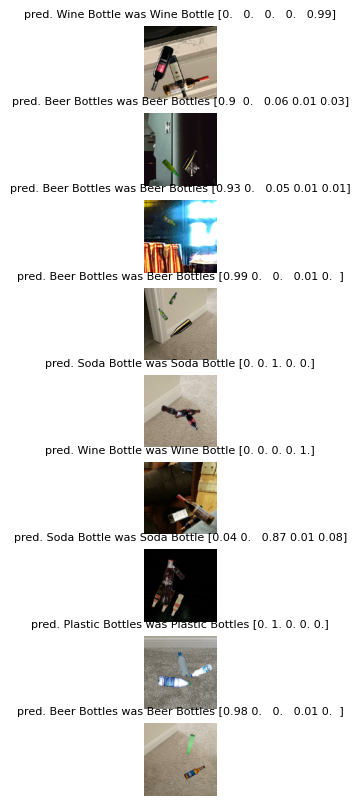

In [20]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions_in_percentage = model.predict_on_batch(image_batch)
# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = np.argmax(predictions_in_percentage, axis=-1)
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(9, 1, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('pred. ' + class_names[predictions[i]] + ' was ' + class_names[label_batch[i]] + ' ' + 	str(np.round(predictions_in_percentage[i], 2)), fontsize=8)
  plt.axis("off")

In [45]:
model.save('bootleclassification-model_transferlearningFinetuningAugmentation.keras')

## Plotting the classification reports and confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-06-08 18:06:17.646205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


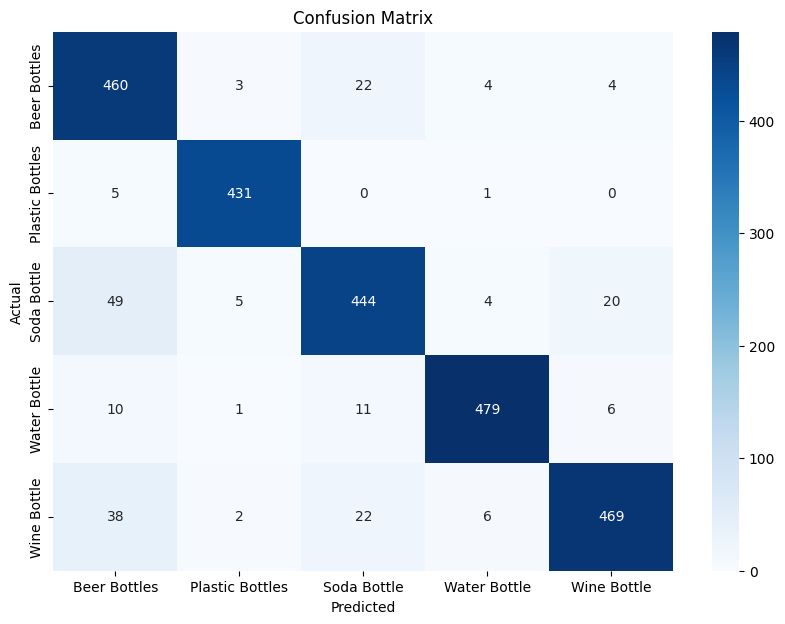

                 precision    recall  f1-score   support

   Beer Bottles       0.82      0.93      0.87       493
Plastic Bottles       0.98      0.99      0.98       437
    Soda Bottle       0.89      0.85      0.87       522
   Water Bottle       0.97      0.94      0.96       507
    Wine Bottle       0.94      0.87      0.91       537

       accuracy                           0.91      2496
      macro avg       0.92      0.92      0.92      2496
   weighted avg       0.92      0.91      0.92      2496



In [28]:
# Evaluation des Modells am Testset, um Labels und Vorhersagen zu erhalten
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Berechnung der Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Erstellung des Classification Reports
print(classification_report(y_true, y_pred, target_names=class_names))

## Summary

- Overall Accuracy: The model achieves an accuracy of 91%.
- Class Performance:
- The model performs best on Plastic Bottles with the highest precision (0.98) and recall (0.99).
- Soda Bottles have the lowest recall (0.85), indicating more confusion with other classes.
- Misclassifications: Most misclassifications occur between similar types of bottles, especially Soda Bottles and Beer Bottles.
- F1-Scores: Indicate a balanced performance across precision and recall for each class, with the lowest being 0.87 for Beer Bottles and Soda Bottles.

The model demonstrates strong performance overall, with particularly high precision and recall for Plastic Bottles and Water Bottles. The confusion matrix and classification report suggest areas where the model could improve, particularly in distinguishing between Soda Bottles and other classes.

## Advanced Data Visualization

### Displaying Feature Maps: 

Visualization of feature maps generated in different layers of the network to understand how the network processes the images.

To determine the exact names of the layers in the model from which the feature maps will be visualized, you can use the following code to list all the layers of the model along with their types.

In [29]:
# Anzeigen der Schichten des Modells und deren Namen
for layer in model.layers:
    print(layer.name, layer.__class__.__name__)

input_layer_1 InputLayer
rescaling Rescaling
xception Functional
global_average_pooling2d GlobalAveragePooling2D
dropout Dropout
dense Dense


For the visualization of feature maps, the outputs of convolutional layers are primarily of interest, as these extract the spatial features in the image data. In this model, there appears to be an Xception layer, which is essentially a complete pre-trained model (a type of Convolutional Neural Network). We can extract the feature maps from various layers within this Xception model.

To do this, the structure of the Xception model must first be explored to find the names of the convolutional layers:

In [30]:
# Zeigt die Struktur des Xception-Modells an
for i, layer in enumerate(model.get_layer('xception').layers):
    print(i, layer.name, layer.__class__.__name__)

0 input_layer InputLayer
1 block1_conv1 Conv2D
2 block1_conv1_bn BatchNormalization
3 block1_conv1_act Activation
4 block1_conv2 Conv2D
5 block1_conv2_bn BatchNormalization
6 block1_conv2_act Activation
7 block2_sepconv1 SeparableConv2D
8 block2_sepconv1_bn BatchNormalization
9 block2_sepconv2_act Activation
10 block2_sepconv2 SeparableConv2D
11 block2_sepconv2_bn BatchNormalization
12 conv2d Conv2D
13 block2_pool MaxPooling2D
14 batch_normalization BatchNormalization
15 add Add
16 block3_sepconv1_act Activation
17 block3_sepconv1 SeparableConv2D
18 block3_sepconv1_bn BatchNormalization
19 block3_sepconv2_act Activation
20 block3_sepconv2 SeparableConv2D
21 block3_sepconv2_bn BatchNormalization
22 conv2d_1 Conv2D
23 block3_pool MaxPooling2D
24 batch_normalization_1 BatchNormalization
25 add_1 Add
26 block4_sepconv1_act Activation
27 block4_sepconv1 SeparableConv2D
28 block4_sepconv1_bn BatchNormalization
29 block4_sepconv2_act Activation
30 block4_sepconv2 SeparableConv2D
31 block4_sep

Based on the list of layers provided from the Xception model, we can select interesting convolutional layers for the visualization of the feature maps. For an effective visualization, we can choose both early and later layers to observe how the features transition from simpler to more complex.

Interesting layers:

	•	block1_conv1: This is an early convolutional layer that might capture basic features like edges and colors.
	•	block2_sepconv2: A deeper layer that might extract more complex features from the inputs.
	•	block14_sepconv2: One of the last convolutional layers that should capture very specific and highly abstract features.

Function created to display the outputs of various layers of the model for specific input images.
Image adjustment: The code takes the first image from a batch.

2024-06-08 18:17:28.861257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
Layer block1_conv1 feature map shape: (1, 74, 74, 32)


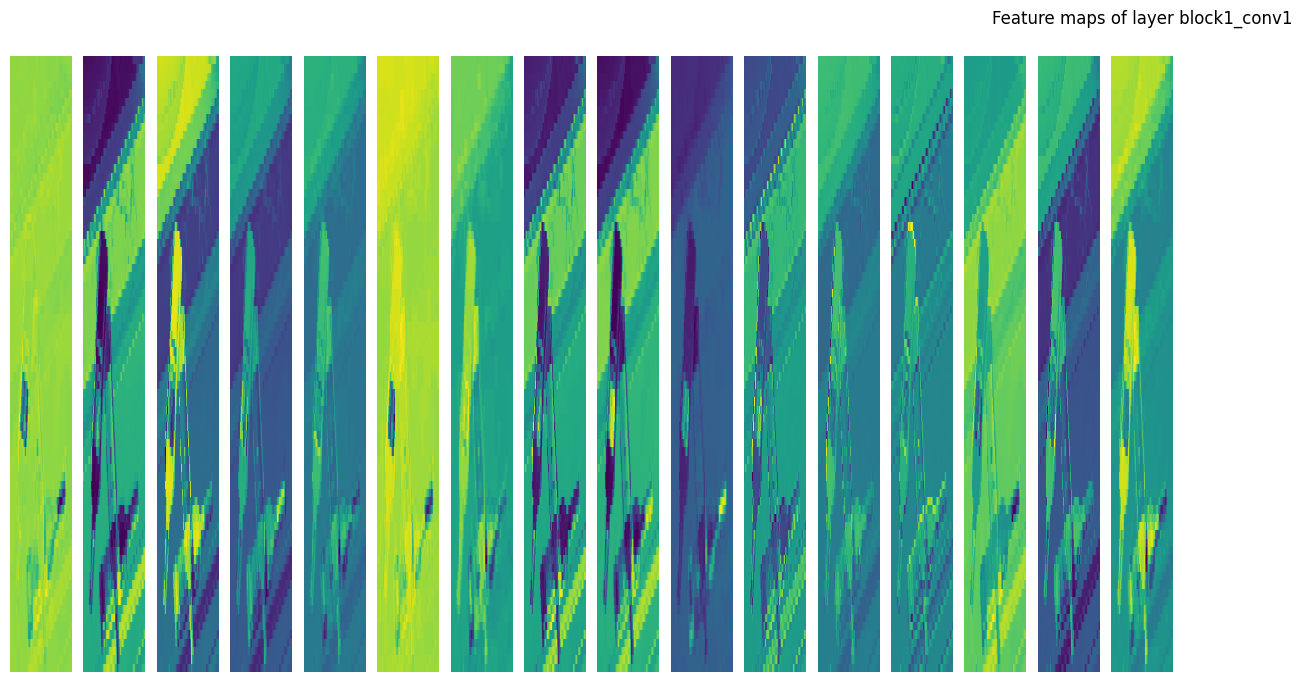

Layer block2_sepconv2 feature map shape: (1, 72, 72, 128)


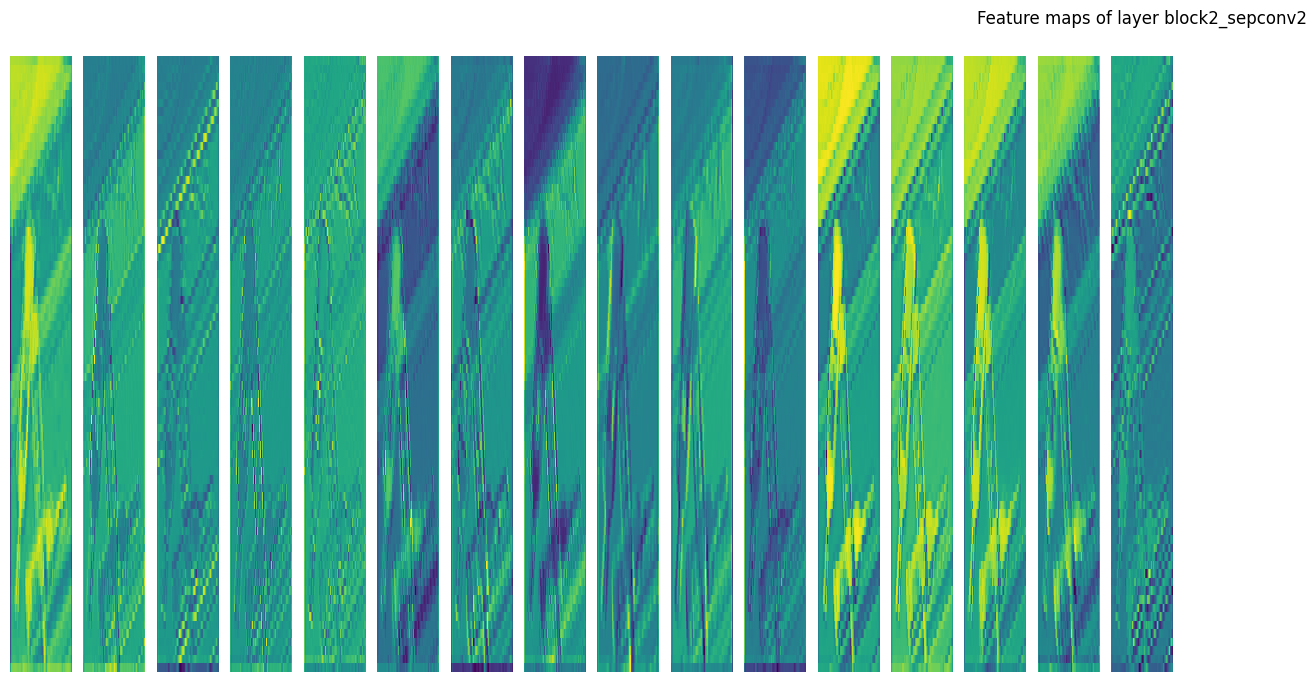

Layer block14_sepconv2 feature map shape: (1, 5, 5, 2048)


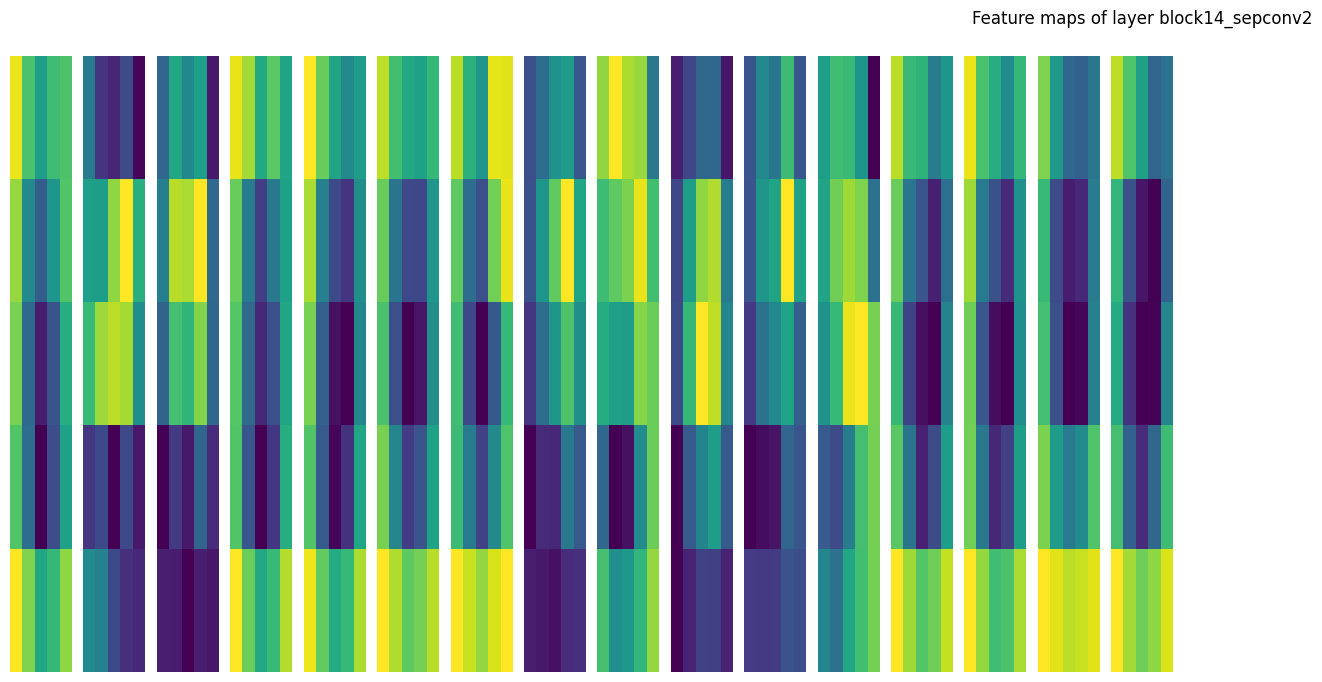

In [31]:
def plot_feature_maps(model, image, layer_names, figsize=(15, 8)):
    """ Visualize the feature maps for specified layers of the model """
    xception_model = model.get_layer('xception')  # Zugriff auf das Xception-Untermodell
    outputs = [xception_model.get_layer(name).output for name in layer_names]
    model_short = tf.keras.Model(inputs=xception_model.input, outputs=outputs)
    
    # Preprocess the image
    image = tf.expand_dims(image, 0)  # Add batch dimension
    
    # Get feature maps
    feature_maps = model_short.predict(image)
    
    # Plotting
    for layer_name, feature_map in zip(layer_names, feature_maps):
        print(f"Layer {layer_name} feature map shape: {feature_map.shape}")
        feature_map = np.squeeze(feature_map, axis=0)  # Remove batch dimension
        num_features = feature_map.shape[-1]
        
        fig, axes = plt.subplots(1, min(num_features, 16), figsize=figsize)  # Limit to displaying 16 features
        axes = axes.flatten()
        
        for i, ax in enumerate(axes):
            if i < num_features:
                ax.matshow(feature_map[..., i], cmap='viridis', aspect='auto')
                ax.axis('off')
            else:
                ax.axis('off')
        
        plt.title(f"Feature maps of layer {layer_name}")
        plt.show()

# Definiere die Schichten, von denen du Feature Maps sehen möchtest
layers_of_interest = ['block1_conv1', 'block2_sepconv2', 'block14_sepconv2']

# Lade ein Beispielbild aus deinem Dataset
for images, _ in test_ds.take(1):
    test_image = images[0].numpy()  # Angenommen, die Bilder sind im uint8-Format

# Rufe die Funktion auf, um Feature Maps zu plotten
plot_feature_maps(model, test_image, layers_of_interest)

Based on the three sets of feature maps, we can gain some insights into how your model processes and abstracts information. Each set represents feature maps from different layers of the Xception model, from earlier to deeper layers.

### Block1_conv1 (First Feature Map)

The feature maps of the `block1_conv1` layer show simple but clear activations that mainly respond to edges and textures. At this early stage of the network:

- **Edge Detection**: The maps clearly show how the network responds to various edge directions in the image. This helps the network identify basic shapes and contours in the image.
- **Simple Texture Features**: Besides edges, simple texture features that appear in certain patterns or recurring structures in the image might also be highlighted.

### Block2_sepconv2 (Second Feature Map)

In the `block2_sepconv2` layer, we see a further development of feature abstraction. These maps are generated by separable convolutional layers, which help improve efficiency while extracting more complex features:

- **More Complex Textures and Shapes**: The maps now seem to respond to more specific patterns and textures that arise from the combination of simple edges. These feature maps help recognize more detailed aspects of the image and contribute to a more precise interpretation of image content.
- **Color and Contrast Sensitivities**: Some maps might also be designed to recognize differences in color and contrast, which are crucial for distinguishing objects in the image space.

### Block14_sepconv2 (Third Feature Map)

The feature maps from `block14_sepconv2`, one of the deeper layers, show how the network recognizes highly abstract features that are important for specific classification tasks:

- **Highly Specific Feature Identification**: These maps are less intuitively interpretable as they respond to highly specific aspects of the image that are not obvious to the human eye. They might identify elements such as the presence of certain objects, complex textures, or specific patterns that were not recognized in earlier layers.
- **Abstraction and Data Reduction**: At this level, the network significantly reduces the dimensionality of the input data and focuses on features that are critical for decision-making. These maps are crucial for the final steps before the classification decision.

By examining these feature maps at various levels of the network, we can see how the level of abstraction increases from identifying simple edges and textures to recognizing specific and abstract patterns necessary for classification. These progressive levels of abstraction help the model transition from general to very specific features, which is essential for making effective predictions.